# Python for Finance
## Assignment 1

### Team: 11
Leonardo Fachetti (2722752)

Marc Peter van Gils (2703225)

Mark de Kwaasteniet (2649271)

### Modules
We will also run a reset, to make sure that no dataframes are packages are stored from previous commands.

In [1]:
%reset
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy
import scipy.stats

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Exercise 1 Part A
Reading in the Json Files of both Equifax and Transunion.

We create both a function for loading the json files and graph creation, since these are two functions that appear more than once.

In [2]:
#Creating a function to load the json files, since there are two files that we need to read. 
def read_json(file,columns):
    
    with open(file) as f:
        data = json.loads(f.read()) #This will load the json file into a dictionary with multiple items.
    
    #Storing the dictionary into a pandas dataframe using the json normalize function, which normalizes a json file into a flat table.
    df_total = pd.json_normalize(data, record_path =['items'])
    
    #Make a datetime variable from the strings in the timestamp column.
    df_total['date'] = pd.to_datetime(df_total['timestamp'], format='%Y%m%d%H')

    #Copying the dataframe and keeping only the columns of interest.
    df_interest = df_total.copy()[columns]

    #Convert the date column, that we made earlier, to the index of the dataframe.
    df_interest = df_interest.set_index(['date']) 
    
    #Returning the dataframe to store it in the dataframe of interest.
    return df_interest

In [3]:
#Creating a function for the graphs that we have to make in this assignment.
def graph_creator(df1,df2,x1,x2,label1,label2,xlabel,ylabel,title):
    
    #Create plot area including axis
    fig, ax = plt.subplots()

    #Set the size of the plot
    fig.set_size_inches(12, 8)

    #Denote the Y and X variable. Then plot the line of both dataframes.
    ax.plot(df1.index, x1, color='purple', label = label1)  
    ax.plot(df2.index, x2, color='green', label = label2)

    #Organize the tickers with an interval and rotation, making the time readable.
    fig.autofmt_xdate() #

    #Create a legend for the figure
    ax.legend()

    #Set the labels for the axes.
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title, fontsize=25, color="Black", fontname='Times New Roman')

Start of the exercises. Reading in the JSON files.

In [4]:
#Storing the names of the columns that we are interested in and need to keep for the analyses.
columns_interest = ['date','views']

#We call the function read_json that we created above and store the dataframes using names of our likings. 
df_eq = read_json('equifax.json',columns_interest)
df_tr = read_json('transunion.json',columns_interest)

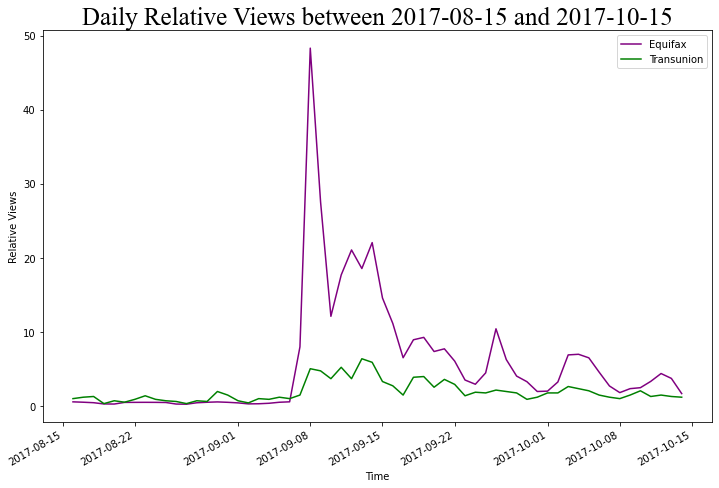

In [5]:
#Set the begin and end date of the time period for the graph
begin_date = '2017-08-15'
end_date = '2017-10-15'

#Create a data set including only the values within the specific time period.
eq_plot = df_eq.loc[(df_eq.index > begin_date) & (df_eq.index < end_date)]
tr_plot = df_tr.loc[(df_tr.index > begin_date) & (df_tr.index < end_date)]

#Add the variable, relative views and fill in the calculation. Note the subtle difference between using the dataframe within the time period and over the total time.
eq_plot = eq_plot.assign(rel_views = eq_plot.views/df_eq.views.mean())
tr_plot = tr_plot.assign(rel_views = tr_plot.views/df_tr.views.mean())

#Create a graph using the aforementioned function 'graph_creator'
graph_creator(eq_plot,tr_plot,eq_plot.rel_views,tr_plot.rel_views,'Equifax','Transunion','Time','Relative Views', 'Daily Relative Views between 2017-08-15 and 2017-10-15')

#### Interpretation of the Daily Relative Views between 2017-08-15 and 2017-10-15
A peak is observed in the relative views of Equifax around the 8th of September in 2017. Sources from internet describe that Equifax had a data breach that came to light in September 2017. Equifax became a victim of cybercrime. 147 million people had their personal data leaked in a data breach that was detected. This explains the high number of relative views on the webpage. We see that the relative views is around 50 at the peak, which means that the number of pageviews is 50 times the average pageviews of the whole data set. Nothing happened to Transunion itself. However, since transunion is also one of the largest credit reporting agencies the event an Equifax resulted in a rise in pageviews for Transunion too.

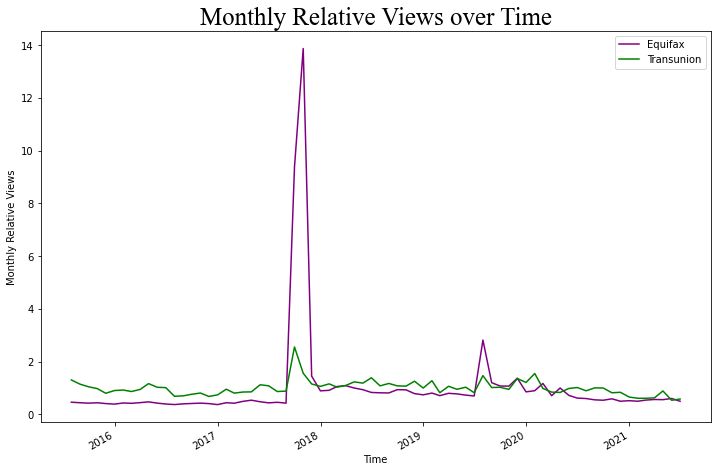

In [6]:
#Using the dataframe over all time, we resample this to monthly values. Summing the number of pageviews within the month.
df_eq_mnthly = df_eq.resample('M').sum()
df_tr_mnthly = df_tr.resample('M').sum()

#Recalculate the monthly relative views and store them in a new column.
df_eq_mnthly = df_eq_mnthly.assign(rel_views = df_eq_mnthly.views/df_eq_mnthly.views.mean())
df_tr_mnthly = df_tr_mnthly.assign(rel_views = df_tr_mnthly.views/df_tr_mnthly.views.mean())

#Create a graph over the whole time period, using the monthly resampled data.
graph_creator(df_eq_mnthly,df_tr_mnthly,df_eq_mnthly.rel_views,df_tr_mnthly.rel_views,'Equifax','Transunion','Time','Monthly Relative Views', 'Monthly Relative Views over Time')

#### Interpretation of the Monthly Relative Views over Time
We see that there is a peak in monthly relative views for both compmanies, however the peak is much higher for Equifax. This is probably because Equifax had the data breach and Transunion did not. However, Transunion still got a little affected in term of relative views by the data breach of Equifax. 

### Exercise 1 Part B

In [7]:
#Reading the complaints file that is downloaded from canvas. Opening in .zip form. 
df_complaints_org = pd.read_csv('complaints.csv.zip') #save in the dataframe _org meaning it is original.

In [8]:
#Store the names of the companies and products we need to filter out of the df. This makes it easy to call the list of strings and look structured.
product_interest = 'Credit reporting, credit repair services, or other personal consumer reports'
companies_interest = ['TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'EQUIFAX, INC.']

#Create a counter variable for every product complain. This will make summing up the number of complaints easier.
df_complaints = df_complaints_org.copy()
df_complaints['complaint_counter'] = 1

# Convert the column Date Received to Datetime variable and set this column as index
df_complaints['Date received'] = pd.to_datetime(df_complaints['Date received'], format='%Y-%m-%d')
df_complaints = df_complaints.set_index(['Date received'])

#Filter on specific products. Only the 'credit reporting, etc'. We do this before filtering the companies, since it holds for both companies. Resulting in one line of code less.
df_eqtr_complaints = df_complaints[df_complaints['Product'].str.contains(product_interest)]

#Filter the data set on the two companies of interest and storing them in different dataframes. Selecting the first and second in the list of companies_interest
df_eq_complaints = df_eqtr_complaints[df_eqtr_complaints['Company'].str.contains(companies_interest[1])]
df_tr_complaints = df_eqtr_complaints[df_eqtr_complaints['Company'].str.contains(companies_interest[0])]

In [9]:
# Keep the Date received (index) and Product columns.
columns_complaint = ['complaint_counter'] #The index will automatically be kept in the dataframe.
df_eq_complaints = df_eq_complaints.copy()[columns_complaint]
df_tr_complaints = df_tr_complaints.copy()[columns_complaint]

# Till this point the data is not yet sorted. We can check this with pandas .sort_index.
# However, using the Resample function sums the values but also sorts on index from first date to last date. 

# Resample at monthly basis, using the sum function to sum up the number of complaints over one month periods. 
df_eq_complaints_monthly = df_eq_complaints.resample('M').sum()
df_tr_complaints_monthly = df_tr_complaints.resample('M').sum()
# NOTE: The number of complaints in April 2017 is significantly lower than the other months, since april only has 7 observations.

# Create a new column for the relative number of complaints on a monthly basis. 
df_eq_complaints_monthly['rel_complaints'] = df_eq_complaints_monthly.complaint_counter/df_eq_complaints_monthly.complaint_counter.mean()
df_tr_complaints_monthly['rel_complaints'] = df_tr_complaints_monthly.complaint_counter/df_tr_complaints_monthly.complaint_counter.mean()

### Exercise 1 - Part B - Task 2
Create a graph of 10 months. Set the begin and end date. 5 months before the data breach is 9 - 5 = 4, meaning april. 5 months after the data breach, including the event is 9+5 = 14, meaning februari, the next year. 

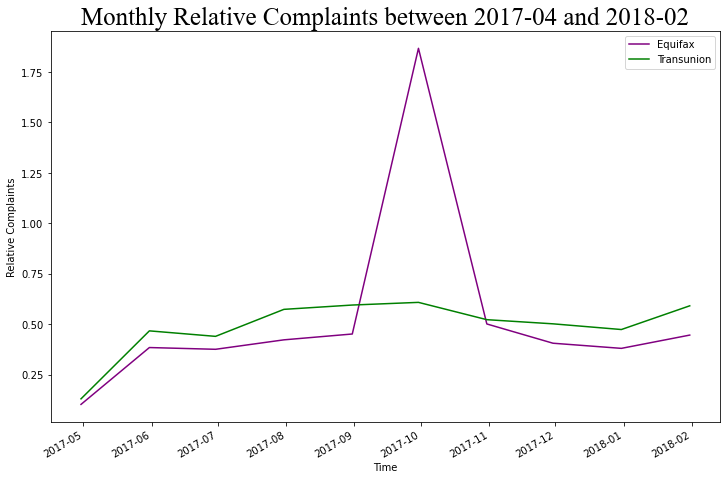

In [10]:
#Set the date strings to easily call the dates in the code later.
begin_date = '2017-04'
end_date = '2018-02'

#Create a new data set between the two dates for the specific plot
eq_complaint_plot = df_eq_complaints_monthly.loc[(df_eq_complaints_monthly.index > begin_date) & (df_eq_complaints_monthly.index < end_date)]
tr_complaint_plot = df_tr_complaints_monthly.loc[(df_tr_complaints_monthly.index > begin_date) & (df_tr_complaints_monthly.index < end_date)]

#Creat the graph using only the data between the aforementioned time periods.
graph_creator(eq_complaint_plot,tr_complaint_plot,eq_complaint_plot.rel_complaints,tr_complaint_plot.rel_complaints,'Equifax','Transunion','Time','Relative Complaints','Monthly Relative Complaints between 2017-04 and 2018-02')

#### Interpretation of the Monthly Relative Complaints between 2017-04 and 2018-02
We see that there is a peak of the relative complaints at Equifax around September and October of 2017. This peak in relative complaints is most definetely linked to the data breach in September 2017. In comparison, the relative complaints of Transunion approximately remained the same. 

In [11]:
#Using the describe function to see the data frame statistic and interpret them for understanding of the data.
print(eq_complaint_plot.describe())
print(tr_complaint_plot.describe())

       complaint_counter  rel_complaints
count          10.000000       10.000000
mean         2765.500000        0.533567
std          2492.242865        0.480846
min           530.000000        0.102257
25%          1975.250000        0.381099
50%          2145.500000        0.413946
75%          2332.000000        0.449929
max          9680.000000        1.867631
       complaint_counter  rel_complaints
count           10.00000       10.000000
mean          1925.50000        0.490125
std            549.99096        0.139997
min            510.00000        0.129817
25%           1840.50000        0.468488
50%           2011.50000        0.512015
75%           2304.75000        0.586660
max           2389.00000        0.608106


#### Interpretation of the data statistics of both the Equifax and Transunion dataframe
When we look at both the data frame of Equifax and Transunion, then we see that the data of Equifax include a peak of 1.89 of relative views, where the mean of the sub data set is only 0.54. This peak is not visible in the Transunion sub data set when comparing the maximum value with the average value. 

### Exercise 1 - Part B - Task 3

In [12]:
# Merge the datasets. The indices are not similar as the .json files have more dates compared to the complaints file.
# The pandas merge function automatically selects the rows for which the indices are identical.
# Therefore it will drop some of the index variables of the page views dataframes since, these are larger and contain more dates.
df_eq_merged = pd.merge(df_eq_mnthly,df_eq_complaints_monthly,left_index=True, right_index=True)
df_tr_merged = pd.merge(df_tr_mnthly,df_tr_complaints_monthly,left_index=True, right_index=True)

In [13]:
#Estimate a regression model where Y is the rel_complaints and X is the rel_views. For both Equifax and Transunion data.
model_eq = ols("rel_complaints~rel_views", df_eq_merged)
est_eq = model_eq.fit()

model_tr = ols("rel_complaints~rel_views", df_tr_merged)
est_tr = model_tr.fit()


In [14]:
print('\033[1m' + 'Equifax Model:'+ '\033[0m', est_eq.summary(),'\n \n','\033[1m' + 'Transunion Model:'+ '\033[0m',est_tr.summary())

Equifax Model:                             OLS Regression Results                            
Dep. Variable:         rel_complaints   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                  0.001521
Date:                Tue, 28 Sep 2021   Prob (F-statistic):              0.969
Time:                        12:22:39   Log-Likelihood:                -49.632
No. Observations:                  51   AIC:                             103.3
Df Residuals:                      49   BIC:                             107.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9039      0.105     

#### Interpretation of the regression model (Relative Complaints on Relative Views) of both Equifax and Transunion
The estimated model using the Equifax data does not contain a significant coefficient (at a 5% significance level). When we look at the magnitude of the coefficient in this model it is surprisingly small, meaning that an increase or decrease in relative views at Equifax has almost no effect whatsoever on the relative complaints at Equifax.
The estimated model using the Transunion data contains a significant coefficient (at a 5% significance level). This means that we can reject the null hypothesis, meaning that the coefficient of relative views at Transunion is not equal to zero. When we look at the magnitude of the coefficient, we see that it has quite some magnitude on the relative complaints at Transunion. Interpretation of this coefficient is as follows: if the relative views at the page of Transunion increases with 1 then the relative complaints at Transunion decreases with 0.77.

### Exercise 2

In [15]:
#Load in the csv data set from CRSP
df_crsp_org = pd.read_csv('crsp.csv')

In [16]:
# Check the TICKERS that we need to extract for equifax and transunion.
df_crsp_org.TICKER.unique()  #EFX and TRU 

# We Store them in a list for later use.
tickers_interest = ['TRU', 'EFX']

In [17]:
#Check the data for strange datatypes as we already see a 'C' if we use head.
df_crsp_org.dtypes #Here we see that the return variable that we need, is an object and not numerical.

PERMNO     int64
date       int64
TICKER    object
RET       object
dtype: object

In [18]:
#Looking into the data documentation there are different strings possible in the RET column: 'C', 'B' and '-'
#We have to make sure that these values are replaced by NaN instead of these strings. 
#We can check seperately if B and - are also in the dataframe or we can replace all just to be sure.
df_crsp = df_crsp_org.copy()
df_crsp.RET.replace('C',np.NaN, inplace=True)
df_crsp.RET.replace('B',np.NaN, inplace=True)
df_crsp.RET.replace('-',np.NaN, inplace=True)

#Check how many missing values the dataset has.
df_crsp.isnull().sum().sum() #1

1

In [19]:
#Drop the rows with NA values 
df_crsp.dropna(inplace=True)

#Now we can make it numerical - float32 bit
df_crsp.RET = pd.to_numeric(df_crsp.RET,downcast='float')

In [20]:
#Convert the date column values into a datetime variable.
df_crsp.date = pd.to_datetime(df_crsp['date'], format='%Y%m%d')

#Set date column as an index for the dataframe
df_crsp = df_crsp.set_index(['date'])

In [21]:
#Seperate the dataframe into two dataframes. One for each company.
df_crsp_eq = df_crsp[df_crsp.TICKER.str.contains(tickers_interest[1])] #Using the stored Ticker strings from before.
df_crsp_tr = df_crsp[df_crsp.TICKER.str.contains(tickers_interest[0])] #Using the first and second string in the list.

In [22]:
#Load in the csv data set from the FAMA FRENCH Three Factor Model
df_ff_org = pd.read_csv('ff.csv')

In [23]:
df_ff_org.dtypes #the variables are allready numerical - float32 bit

dateff      int64
mktrf     float64
rf        float64
dtype: object

In [24]:
#Retain the original df
df_ff = df_ff_org.copy()

#Check for 
df_ff.isnull().sum().sum() #0

0

In [25]:
#Convert the dateff column values into a datetime variable.
df_ff['dateff'] = pd.to_datetime(df_ff['dateff'], format='%Y%m%d')

#Set dateff column as an index for the dataframe
df_ff = df_ff.set_index(['dateff'])

In [26]:
#Merge the return and FF dataframes, using index. The dataframes have the same lenght in terms of time periods. Therefore, we don't have to worry about automatically dropping values
df_eq_ff_merged = pd.merge(df_ff,df_crsp_eq,left_index=True, right_index=True)
df_tr_ff_merged = pd.merge(df_ff,df_crsp_tr,left_index=True, right_index=True)

In [27]:
#The CRSP and FF dataframes are monthly data but they lack the 31th of october in 2020 for example.
#To make sure that the indices of these dataframes and the complaints are equal we are resampling the crsp and FF data.
#This might seem a little redundant, however, since the monthly value is already calculated it will only change the index.
df_eq_ff_merged = df_eq_ff_merged.resample('M').mean()
df_tr_ff_merged = df_tr_ff_merged.resample('M').mean()

#Merge the Equifax and Transunion dataframes with the complaints/view dataframes
#Now we need to be carefull with this merge since, the complaints file only has data from april 2017 on.
#Therefore we merge with using only the index of the crsp/ff with the .join function. 
df_eq_car = df_eq_ff_merged.join(df_eq_merged) #This will result in a complete data set where the missing values are filled with NaN
df_tr_car = df_tr_ff_merged.join(df_tr_merged)

In [28]:
#Keep only interested variables
variables_interest = ['mktrf','rf','RET','rel_views','rel_complaints']

df_eq_car = df_eq_car.copy()[variables_interest]
df_tr_car = df_tr_car.copy()[variables_interest]

### Exercise 2 - Task 2

In [29]:
# Estimate the beta using the CAPM. First, create the excess return variable and store the values in a column for each company.
df_eq_car = df_eq_car.assign(excess_ret = df_eq_car.RET - df_eq_car.rf)
df_tr_car = df_tr_car.assign(excess_ret = df_tr_car.RET - df_tr_car.rf)

# The question notes that we should only use the data pre-2017. Therefore, we are calculating the beta using the pre-2017 data.
# Keeping this dataframe and create a new dataframe that is pre-2017
df_eq_car_pre2017 = df_eq_car.loc[(df_eq_car.index < '2017')]
df_tr_car_pre2017 = df_tr_car.loc[(df_tr_car.index < '2017')]

In [30]:
#Estimate the beta, using the CAPM - running a simple OLS regression. Equifax
model_eq_pre2017 = ols("excess_ret~mktrf", df_eq_car_pre2017)
est_eq_pre2017 = model_eq_pre2017.fit()

#Store the estimated beta
beta_eq_pre2017 = est_eq_pre2017.params[1]

In [31]:
#Estimate the beta, using the CAPM - running a simple OLS regression. Transunion
model_tr_pre2017 = ols("excess_ret~mktrf", df_tr_car_pre2017)
est_tr_pre2017 = model_tr_pre2017.fit()

#Store the estimated beta
beta_tr_pre2017 = est_tr_pre2017.params[1]

In [32]:
#Calculate the expected return using the pre-2017 sample averages for both Equifax and Transunion
expected_return_eq = (df_eq_car_pre2017.rf.mean() +(beta_eq_pre2017*df_eq_car_pre2017.mktrf.mean()))
expected_return_tr = (df_tr_car_pre2017.rf.mean() +(beta_tr_pre2017*df_tr_car_pre2017.mktrf.mean()))

#Calculate the abnormal returns for the whole data set and store it in a new column in both data frames.
df_eq_car = df_eq_car.assign(abnormal_return = df_eq_car.RET - expected_return_eq)
df_tr_car = df_tr_car.assign(abnormal_return = df_tr_car.RET - expected_return_tr)

In [33]:
# Create a graph of 12 months.
# Set the begin and end date. 6 months before the event = 9-6 = 3 (March 2017). 6 months after (including event month) which is 9+6 = 15 (March 2018).
begin_date = '2017-03'
end_date = '2018-03'

#Create two dataframes that only contain the 12 month interested period
df_eq_car_event = df_eq_car.loc[(df_eq_car.index > begin_date) & (df_eq_car.index < end_date)]
df_tr_car_event = df_tr_car.loc[(df_tr_car.index > begin_date) & (df_tr_car.index < end_date)]

In [34]:
#Add 1 on every abnormal return and store in a new variable as preparation to create the cumulative returns
df_eq_car_event = df_eq_car_event.assign(abnormal_return1 = df_eq_car_event.abnormal_return+1)
df_tr_car_event = df_tr_car_event.assign(abnormal_return1 = df_tr_car_event.abnormal_return+1)

In [35]:
#Calculate the CAR by cumulating the abnormal returns + 1 and subtracting 1 after the cumulative process. 
df_eq_car_event = df_eq_car_event.assign(car = df_eq_car_event.abnormal_return1.cumprod()-1)
df_tr_car_event = df_tr_car_event.assign(car = df_tr_car_event.abnormal_return1.cumprod()-1)

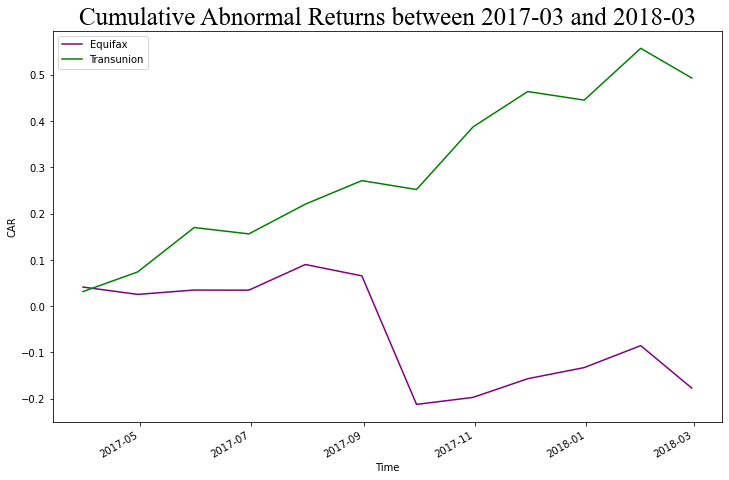

In [36]:
#Creat a graph that plots the CAR of both Equifax and Transunion in the 12 month period. 
graph_creator(df_eq_car_event,df_tr_car_event,df_eq_car_event.car,df_tr_car_event.car,'Equifax','Transunion','Time','CAR','Cumulative Abnormal Returns between 2017-03 and 2018-03')


#### Interpration of the Cumulative Abnormal Returns between 2017-03 and 2018-03
We see that the Cumulative Abnormal Returns(CAR) decrease for Equifax at the time of the event, which is September 2017. If we compare this with Transunion,  we see the opposite since the CAR increases after the event (which happened at Equifax). We expect that the decrease of the CAR at Equifax also supported some of the increasing CAR of Transunion, since people that would be less satisfied with Equifax after the data breach could change to Transunion, reulsting in a decrease in the price of Equifax and thus an increase in the demand for Transunion.

### Exercise 2 - Task 3

We will estimate the effect of the lagged relative- views and complaints on the Excess Stock Returns of both companies using the following model:

$R_{i,t} - R_f = \alpha + \beta_1RelViews_{i,t-1} + \beta_2RelComplaints_{i,t-1} + \epsilon_{i,t}$


In [37]:
#Running a simple OLS regression of the aforementioned model. Note that the OLS function automatically only select the indices, where complaints and views have values.
#We should also us the .shift function to have the lagged variables in the regression. 
#Equifax
model_eq = ols("excess_ret~rel_views.shift(+1) + rel_complaints.shift(+1)", df_eq_car)
est_eq = model_eq.fit()

#Transunion
model_tr = ols("excess_ret~rel_views.shift(+1) + rel_complaints.shift(+1)", df_tr_car)
est_tr = model_tr.fit()

In [38]:
print('\033[1m' + 'Equifax Model:'+ '\033[0m', est_eq.summary(),'\n \n','\033[1m' + 'Transunion Model:'+ '\033[0m',est_tr.summary())

Equifax Model:                             OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9714
Date:                Tue, 28 Sep 2021   Prob (F-statistic):              0.387
Time:                        12:22:39   Log-Likelihood:                 42.035
No. Observations:                  44   AIC:                            -78.07
Df Residuals:                      41   BIC:                            -72.72
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept

#### Interpretation of the regression models of both the Equifax and Transunion data frames
Looking at both the estimated regression models (Equifax and Transunion) we conclude, due to low t-statistics and high p-values, that there is no predictive power of Relative Views or Relative Complaints on the Excess Stock Returns of the companies. All the coefficients (in both models) are not significant (at 5% significance level), meaning we are not able to reject the null-hypothesis that the estimated coefficients are equal to zero. 